# NB01: Build the BacDive → Pangenome → Metal Score Bridge

Link BacDive strains to pangenome species and metal tolerance scores via species name matching.

**Bridge chain**: BacDive taxonomy (species name) → GTDB species name → species_metal_scores.csv

In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

PROJ = os.path.abspath('..')
MAIN_REPO = '/home/psdehal/pangenome_science/BERIL-research-observatory'
BACDIVE = os.path.join(MAIN_REPO, 'data', 'bacdive_ingest')
METAL_ATLAS = os.path.join(MAIN_REPO, 'projects', 'metal_fitness_atlas', 'data')
DATA_OUT = os.path.join(PROJ, 'data')
FIG_OUT = os.path.join(PROJ, 'figures')
os.makedirs(DATA_OUT, exist_ok=True)
os.makedirs(FIG_OUT, exist_ok=True)

## Load BacDive data

In [2]:
# Taxonomy
tax = pd.read_csv(os.path.join(BACDIVE, 'taxonomy.tsv'), sep='\t')
print(f'BacDive taxonomy: {len(tax)} strains, {tax["species"].nunique()} species')

# Isolation source
iso = pd.read_csv(os.path.join(BACDIVE, 'isolation.tsv'), sep='\t')
print(f'Isolation records: {len(iso)}')

# Sequence info (genome accessions)
seq = pd.read_csv(os.path.join(BACDIVE, 'sequence_info.tsv'), sep='\t')
genomes = seq[seq['accession_type'] == 'genome']
print(f'Genome accessions: {len(genomes)} for {genomes["bacdive_id"].nunique()} strains')

# Metabolite utilization
met = pd.read_csv(os.path.join(BACDIVE, 'metabolite_utilization.tsv'), sep='\t')
print(f'Metabolite utilization records: {len(met)}')

BacDive taxonomy: 97334 strains, 21675 species
Isolation records: 57935


Genome accessions: 27502 for 19592 strains


Metabolite utilization records: 988259


## Load metal tolerance scores

In [3]:
scores = pd.read_csv(os.path.join(METAL_ATLAS, 'species_metal_scores.csv'))
print(f'Metal scores: {len(scores)} species')

# Extract species name from gtdb_species_clade_id
# Format: s__Genus_species--RS_GCF_000742135.1
scores['gtdb_species_name'] = scores['gtdb_species_clade_id'].str.extract(r's__(.+?)--')[0]
scores['gtdb_species_name'] = scores['gtdb_species_name'].str.replace('_', ' ')

# Also create a version without GTDB suffixes (_A, _B, etc.) for fuzzy matching
scores['gtdb_species_base'] = scores['gtdb_species_name'].str.replace(r' [A-Z]$', '', regex=True)
scores['gtdb_species_base'] = scores['gtdb_species_base'].str.replace(r' [A-Z] ', ' ', regex=True)

print(f'Example GTDB species names: {scores["gtdb_species_name"].head(5).tolist()}')
print(f'Example base names: {scores["gtdb_species_base"].head(5).tolist()}')

Metal scores: 27702 species
Example GTDB species names: ['Pantoea A carbekii', 'Kinetoplastibacterium blastocrithidii', 'Kinetoplastibacterium crithidii', 'Buchnera aphidicola', 'Buchnera aphidicola AO']
Example base names: ['Pantoea carbekii', 'Kinetoplastibacterium blastocrithidii', 'Kinetoplastibacterium crithidii', 'Buchnera aphidicola', 'Buchnera aphidicola AO']


## Build the species name bridge

In [4]:
# Strategy: match BacDive species names to GTDB species names
# GTDB often renames species with suffixes like _A, _B
# Try exact match first, then fall back to base name match

# Build lookup: GTDB species name → best metal score
# (multiple GTDB species can map to one name; take the one with most genomes)
scores_sorted = scores.sort_values('no_genomes', ascending=False)

# Exact match lookup
exact_lookup = scores_sorted.drop_duplicates(subset='gtdb_species_name', keep='first')
exact_lookup = exact_lookup.set_index('gtdb_species_name')[['gtdb_species_clade_id', 'metal_score_raw', 'metal_score_norm', 'no_genomes', 'no_gene_clusters']]

# Base name lookup (for GTDB suffix removal)
base_lookup = scores_sorted.drop_duplicates(subset='gtdb_species_base', keep='first')
base_lookup = base_lookup.set_index('gtdb_species_base')[['gtdb_species_clade_id', 'metal_score_raw', 'metal_score_norm', 'no_genomes', 'no_gene_clusters']]

# Match BacDive species to GTDB
def match_species(bacdive_species):
    """Try exact match, then base name match."""
    if pd.isna(bacdive_species):
        return None, 'no_species'
    
    # Exact match
    if bacdive_species in exact_lookup.index:
        return exact_lookup.loc[bacdive_species], 'exact'
    
    # Base name match (handles GTDB _A/_B suffixes)
    if bacdive_species in base_lookup.index:
        return base_lookup.loc[bacdive_species], 'base_name'
    
    return None, 'no_match'

# Apply matching to all BacDive strains
results = []
for _, row in tax.iterrows():
    match, match_type = match_species(row['species'])
    entry = {
        'bacdive_id': row['bacdive_id'],
        'bacdive_species': row['species'],
        'bacdive_genus': row['genus'],
        'bacdive_phylum': row['phylum'],
        'match_type': match_type,
    }
    if match is not None:
        entry['gtdb_species_clade_id'] = match['gtdb_species_clade_id']
        entry['metal_score_raw'] = match['metal_score_raw']
        entry['metal_score_norm'] = match['metal_score_norm']
        entry['no_genomes'] = match['no_genomes']
    results.append(entry)

bridge = pd.DataFrame(results)

# Match rate summary
match_counts = bridge['match_type'].value_counts()
print('Match rates:')
for mt, count in match_counts.items():
    print(f'  {mt:15s}: {count:6d} ({100*count/len(bridge):.1f}%)')

matched = bridge[bridge.match_type.isin(['exact', 'base_name'])]
print(f'\nTotal matched: {len(matched)} / {len(bridge)} strains ({100*len(matched)/len(bridge):.1f}%)')
print(f'Unique GTDB species matched: {matched["gtdb_species_clade_id"].nunique()}')

Match rates:
  no_match       :  55107 (56.6%)
  exact          :  33535 (34.5%)
  base_name      :   8692 (8.9%)

Total matched: 42227 / 97334 strains (43.4%)
Unique GTDB species matched: 6426


## Add isolation source data

In [5]:
# Join isolation source to bridge
bridge_iso = bridge.merge(iso[['bacdive_id', 'sample_type', 'cat1', 'cat2', 'cat3', 'country']], 
                          on='bacdive_id', how='left')

# How many matched strains have isolation data?
matched_with_iso = bridge_iso[(bridge_iso.match_type.isin(['exact', 'base_name'])) & (bridge_iso.cat1.notna())]
print(f'Matched strains with isolation data: {len(matched_with_iso)}')
print(f'\nIsolation categories for matched strains:')
print(matched_with_iso['cat1'].value_counts().to_string())

print(f'\nContamination sub-categories:')
contam = matched_with_iso[matched_with_iso.cat2 == '#Contamination']
print(f'  Total contamination: {len(contam)}')
print(contam['cat3'].value_counts().to_string())

print(f'\nHeavy metal contamination isolates with metal scores:')
hm = matched_with_iso[matched_with_iso.cat3 == '#Heavy metal']
print(f'  n = {len(hm)}')
if len(hm) > 0:
    print(f'  Species: {hm["bacdive_species"].value_counts().head(10).to_string()}')

Matched strains with isolation data: 25089

Isolation categories for matched strains:
cat1
#Host                 12086
#Environmental         7356
#Engineered            3522
#Infection              887
#Host Body-Site         589
#Host Body Product      561
#Condition               82
#Climate                  6

Contamination sub-categories:
  Total contamination: 176
cat3
#Oil (Fuel)     30
#Heavy metal    10

Heavy metal contamination isolates with metal scores:
  n = 10
  Species: bacdive_species
Cupriavidus campinensis         1
Clostridium chromiireducens     1
Deinococcus indicus             1
Leucobacter luti                1
Cellulosimicrobium cellulans    1
Halopseudomonas bauzanensis     1
Amycolatopsis tucumanensis      1
Agromyces aureus                1
Luteimonas arsenica             1
Herbaspirillum robiniae         1


In [6]:
# Save the full bridge
bridge_iso.to_csv(os.path.join(DATA_OUT, 'bacdive_pangenome_bridge.csv'), index=False)
print(f'Saved: data/bacdive_pangenome_bridge.csv ({len(bridge_iso)} rows)')

# Save matched-only subset for downstream notebooks
matched_only = bridge_iso[bridge_iso.match_type.isin(['exact', 'base_name'])].copy()
matched_only.to_csv(os.path.join(DATA_OUT, 'matched_strains.csv'), index=False)
print(f'Saved: data/matched_strains.csv ({len(matched_only)} rows)')

# Summary stats
print(f'\n=== Bridge Summary ===')
print(f'BacDive strains: {len(bridge)}')
print(f'Matched to pangenome: {len(matched_only)} ({100*len(matched_only)/len(bridge):.1f}%)')
print(f'  Exact match: {(matched_only.match_type == "exact").sum()}')
print(f'  Base name match: {(matched_only.match_type == "base_name").sum()}')
print(f'With isolation data: {matched_only["cat1"].notna().sum()}')
print(f'Metal score range: {matched_only["metal_score_norm"].min():.3f} - {matched_only["metal_score_norm"].max():.3f}')
print(f'Metal score median: {matched_only["metal_score_norm"].median():.3f}')

Saved: data/bacdive_pangenome_bridge.csv (97334 rows)
Saved: data/matched_strains.csv (42227 rows)

=== Bridge Summary ===
BacDive strains: 97334
Matched to pangenome: 42227 (43.4%)
  Exact match: 33535
  Base name match: 8692
With isolation data: 25089
Metal score range: 0.078 - 0.387
Metal score median: 0.187


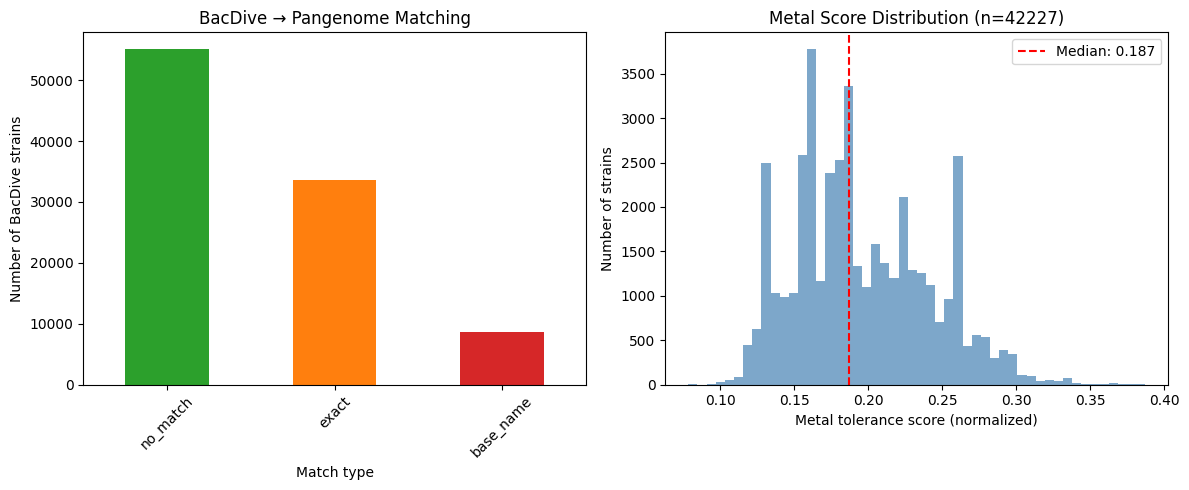

Saved: figures/bridge_summary.png


In [7]:
# Visualization: match rate and score distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Panel 1: Match type breakdown
match_counts.plot.bar(ax=axes[0], color=['#2ca02c', '#ff7f0e', '#d62728'])
axes[0].set_xlabel('Match type')
axes[0].set_ylabel('Number of BacDive strains')
axes[0].set_title('BacDive → Pangenome Matching')
axes[0].tick_params(axis='x', rotation=45)

# Panel 2: Metal score distribution for matched strains
axes[1].hist(matched_only['metal_score_norm'].dropna(), bins=50, color='steelblue', alpha=0.7)
axes[1].set_xlabel('Metal tolerance score (normalized)')
axes[1].set_ylabel('Number of strains')
axes[1].set_title(f'Metal Score Distribution (n={len(matched_only)})')
axes[1].axvline(x=matched_only['metal_score_norm'].median(), color='red', linestyle='--', 
                label=f'Median: {matched_only["metal_score_norm"].median():.3f}')
axes[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(FIG_OUT, 'bridge_summary.png'), dpi=150, bbox_inches='tight')
plt.show()
print('Saved: figures/bridge_summary.png')